# Detecting bullying Tweets with PyTorch Bidirectional LSTM and BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using Bidirectional LSTM and BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:
- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary


## Custom functions definition:

In [1]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

## Import libraries

In [2]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Seed for reproducibility
import random
import torch
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)



import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

## Data Import

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("cyberbullying_tweets.csv")
df_public = pd.read_csv('public_data_labeled.csv')
df_scraped = pd.read_csv('labeled_tweets.csv')

In [5]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [6]:
df_public = pd.concat([df_scraped, df_public])

In [7]:
df_public.tail()

,label,full_text
24778,Offensive,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,Non-offensive,"you've gone and broke the wrong heart baby, an..."
24780,Offensive,young buck wanna eat!!.. dat nigguh like I ain...
24781,Offensive,youu got wild bitches tellin you lies
24782,Non-offensive,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [8]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [7]:
df_public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      24783 non-null  object
 1   full_text  24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB


First we rename the columns using shorter words for easier reference.

In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [41]:
df_public = df_public.rename(columns={'full_text': 'text'})

In [11]:
df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [42]:
df_public.head()

,label,text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...
4,Offensive,Hopefully someone cooks Drasko in the next ep ...
6,Offensive,of course you were born in serbia...you're as ...
7,Offensive,These girls are the equivalent of the irritati...


### Are there duplicated tweets?

In [12]:
df.duplicated().sum()

43

In [25]:
df_public.duplicated().sum()

0

There are some duplicated tweets, we will remove them.

In [13]:
df = df[~df.duplicated()]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47649 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47649 non-null  object
 1   sentiment  47649 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


religion               7997
age                    7990
ethnicity              7959
gender                 7945
not_cyberbullying      7937
other_cyberbullying    7821
Name: sentiment, dtype: int64

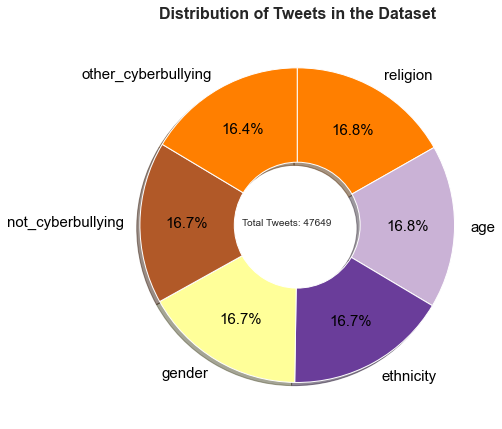

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (7,7))

sorted_counts = df['sentiment'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16)
sorted_counts

Offensive        23531
Non-offensive    12256
Name: label, dtype: int64

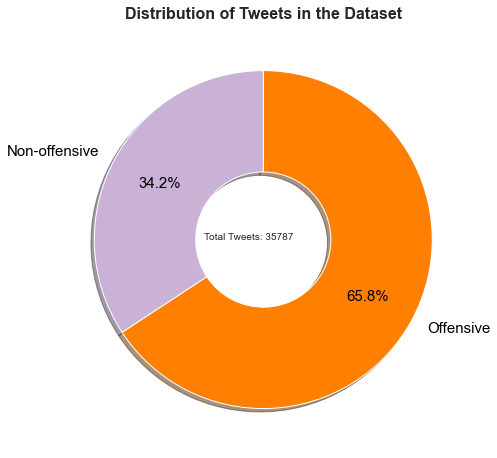

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (7,7))

sorted_counts = df_public['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df_public.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16)
sorted_counts

In [44]:
df_public['label'] = df_public.label.map({'Offensive': 1, 'Non-offensive': 0})

In [45]:
df_public.head()

,label,text
0,1,So Drasko just said he was impressed the girls...
2,1,Drasko they didn't cook half a bird you idiot ...
4,1,Hopefully someone cooks Drasko in the next ep ...
6,1,of course you were born in serbia...you're as ...
7,1,These girls are the equivalent of the irritati...


### Are the classes balanced?

In [17]:
df.sentiment.value_counts()

religion               7997
age                    7990
ethnicity              7959
gender                 7945
not_cyberbullying      7937
other_cyberbullying    7821
Name: sentiment, dtype: int64

In [46]:
df_public.label.value_counts()

1    23531
0    12256
Name: label, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [18]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [19]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

<ipython-input-18-1ee7ef266735>:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [48]:
texts_new = []
for t in df_public.text:
    texts_new.append(deep_clean(t))

<ipython-input-47-1ee7ef266735>:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [20]:
df_public['text_clean'] = texts_new

ValueError: Length of values (47649) does not match length of index (35787)

In [21]:
df['text_clean'] = texts_new

In [22]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


In [50]:
df_public.head()

,label,text,text_clean
0,1,So Drasko just said he was impressed the girls...,drasko said impress girl cook half chicken coo...
2,1,Drasko they didn't cook half a bird you idiot ...,drasko cook half bird idiot mkr
4,1,Hopefully someone cooks Drasko in the next ep ...,hope someon cook drasko next ep mkr
6,1,of course you were born in serbia...you're as ...,cours born serbiay fuck serbian film mkr
7,1,These girls are the equivalent of the irritati...,girl equival irrit asian girl coupl year ago w...


### Are there duplicate tweets after the cleaning?

In [23]:
df.shape

(47649, 3)

In [24]:
df["text_clean"].duplicated().sum()

3061

In [51]:
df_public["text_clean"].duplicated().sum()

1144

There are around 3000 duplicated tweets, we will remove them.

In [25]:
df.drop_duplicates("text_clean", inplace=True)

In [52]:
df_public.drop_duplicates("text_clean", inplace=True)

In [26]:
df.shape

(44588, 3)

In [54]:
df_public.shape

(34643, 3)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [27]:
df.sentiment.value_counts()

religion               7945
age                    7881
ethnicity              7743
not_cyberbullying      7637
gender                 7604
other_cyberbullying    5778
Name: sentiment, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [28]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [29]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [98]:
labels = ["Offensive", "Non-Offensive"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [35]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [36]:
text_len = []
for text in df_public.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

AttributeError: 'DataFrame' object has no attribute 'text_clean'

In [37]:
df['text_len'] = text_len

ValueError: Length of values (0) does not match length of index (38810)

In [139]:
df_public['text_len'] = text_len
len(text_len)

34643

In [38]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

KeyError: 'text_len'

<Figure size 504x360 with 0 Axes>

We will remove tweets that are too short (less than 4 words).

In [39]:
df = df[df['text_len'] > 3]

KeyError: 'text_len'

### What about long tweets?

In [29]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore s...,162
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilti kill feel guilti enjoy torment sin...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
6311,@SteveStreza but you might ask @cperciva - i'm...,not_cyberbullying,might ask pretti sure,4
6308,RT @ashleylynch: No remark necessary for this ...,not_cyberbullying,rt remark necessari one,4
6263,@tarah @girlziplocked @hypatiadotca @justkelly...,not_cyberbullying,well support lost mine,4
6254,@nicollezinha1 @Anniiinhah_ a nicol sofreu bul...,not_cyberbullying,nicol sofreu bulli kkkkkkkkkk,4


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

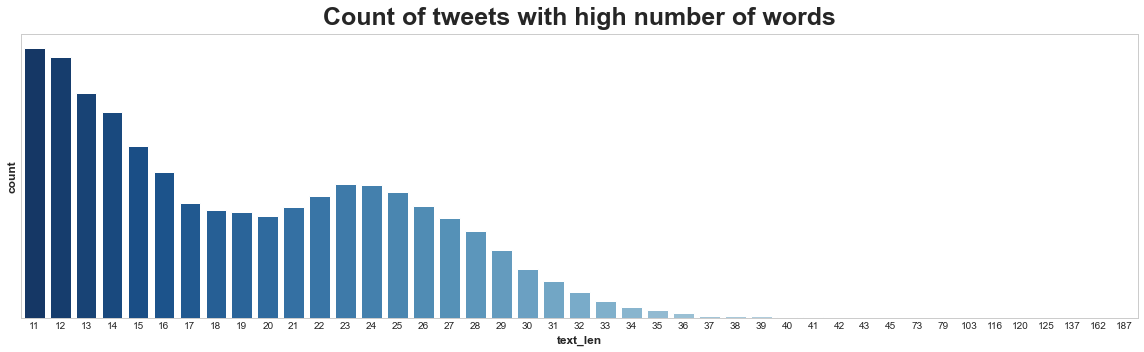

In [30]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [31]:
df = df[df['text_len'] < 100]

Then we also get the length of the longest tweet since it will be useful later.

In [32]:
max_len = np.max(df['text_len'])
max_len 

79

In [140]:
max_len = np.max(df_public['text_len'])
max_len 

29

In [33]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
...,...,...,...,...
40899,@SkillzFrom86 YOU DUMB FUCK U ARE A NIGGER,ethnicity,dumb fuck u nigger,4
4931,@SofapakaCoach will you sign Tom Bayeye? Lol!,not_cyberbullying,sign tom bayey lol,4
42644,@sharellmariee Why the fuck would he do it the...,ethnicity,fuck would dumb nigger,4
13986,"Men ""have a discussion."" Women ""argue.""",gender,men discuss women argu,4


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [30]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [35]:
df['sentiment']

0        4
1        4
2        4
3        4
4        4
        ..
47687    2
47688    2
47689    2
47690    2
47691    2
Name: sentiment, Length: 37104, dtype: int64

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [31]:
X = df['text_clean']
y = df['sentiment']


In [63]:
x_bin = df_public['text_clean']
y_bin = df_public['label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [33]:
len(X_train)

31048

In [34]:
len(X_test)

7762

In [64]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(x_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [65]:
X_train_bin, X_valid_bin, y_train_bin, y_valid_bin = train_test_split(X_train_bin, y_train_bin, test_size=0.1, stratify=y_train_bin, random_state=seed_value)

In [41]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5720],
       [   1, 5674],
       [   2, 5575],
       [   3, 5475],
       [   4, 5499]], dtype=int64)

In [66]:
(unique, counts) = np.unique(y_train_bin, return_counts=True)
np.asarray((unique, counts)).T

array([[    0,  8480],
       [    1, 16462]], dtype=int64)

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [42]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [59]:
ros = RandomOverSampler()
X_train_bin, y_train_bin = ros.fit_resample(np.array(X_train_bin).reshape(-1, 1), np.array(y_train_bin).reshape(-1, 1));
train_os_bin = pd.DataFrame(list(zip([x[0] for x in X_train_bin], y_train_bin)), columns = ['text_clean', 'label']);

In [43]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [61]:
X_train_bin = train_os_bin['text_clean'].values
y_train_bin = train_os_bin['label'].values

In [44]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5720],
       [   1, 5720],
       [   2, 5720],
       [   3, 5720],
       [   4, 5720]], dtype=int64)

In [62]:
(unique, counts) = np.unique(y_train_bin, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 16462],
       [    1, 16462]], dtype=int64)

In [132]:
X_train[0]

'littl brother destroy summer school bulli fortnit 1v1 via'

In [130]:
y_train

array([1, 2, 4, ..., 4, 4, 4], dtype=int64)

In [83]:
X_train_bin.tail()

16489    rt dont faggot cover mouth fkn cough sneez got...
19105                 rt rt would marri scarlett johansson
21158                               stiff arm hoe ass lmao
7017     save best materi wmh game ya know ju rain hell...
599       yo bitch horn tryna shoot porn shirt worthi toni
Name: text_clean, dtype: object

In [71]:
y_train_bin[1]

1

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [48]:
clf = CountVectorizer()


In [135]:
len(X_train)

28410

In [78]:
len(X_train_bin)

24942

In [49]:
X_train_cv =  clf.fit_transform(X_train)


In [85]:
X_train_bin_cv = clf.fit_transform(X_train_bin)

In [50]:
X_train_cv

<28600x27550 sparse matrix of type '<class 'numpy.int64'>'
	with 374545 stored elements in Compressed Sparse Row format>

In [86]:
X_train_bin_cv

<24942x19262 sparse matrix of type '<class 'numpy.int64'>'
	with 191103 stored elements in Compressed Sparse Row format>

In [51]:
X_train_cv.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [87]:
X_train_bin_cv.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [140]:
clf.get_feature_names() # TODO : clean the numbers as well

C:\Users\chira\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000',
 '0006',
 '00you',
 '010',
 '01867',
 '0255',
 '05',
 '0505',
 '05mn',
 '06',
 '07',
 '0853am',
 '0911',
 '0f',
 '0lace',
 '0o',
 '0rang',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100000000',
 '10000000chill',
 '100010',
 '100b',
 '100bc',
 '100k',
 '100lb',
 '100th',
 '100year',
 '101',
 '1010',
 '1013',
 '1015',
 '1018',
 '102',
 '102000',
 '102216',
 '1030',
 '10324830m',
 '104',
 '1040',
 '105',
 '105b',
 '106',
 '1063',
 '1095',
 '10inch',
 '10k',
 '10m',
 '10mil',
 '10mkr',
 '10pm',
 '10reserv',
 '10right',
 '10th',
 '10th11th12th',
 '10to1',
 '10x',
 '10yearold',
 '10yearsof1d',
 '10yr',
 '11',
 '110',
 '1100',
 '1100am',
 '110830tran',
 '110th',
 '1112',
 '1114',
 '1116',
 '11415',
 '115',
 '115th',
 '11pm',
 '11th',
 '11year',
 '11yr',
 '12',
 '120',
 '1200',
 '1202021',
 '1213in',
 '1214',
 '1223',
 '123',
 '1233',
 '125',
 '1250',
 '125th',
 '128',
 '128517',
 '128524',
 '128525',
 '128529',
 '128530',
 '128563128586',
 '128564128075',
 '128584',
 '12859

In [52]:

X_test_cv = clf.transform(X_test)

In [88]:
X_test_bin_cv = clf.transform(X_test_bin)

In [155]:
X_train_cv.todense()[0]



matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [143]:
clf.get_feature_names()

['00',
 '000',
 '0006',
 '00you',
 '010',
 '01867',
 '0255',
 '05',
 '0505',
 '05mn',
 '06',
 '07',
 '0853am',
 '0911',
 '0f',
 '0lace',
 '0o',
 '0rang',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100000000',
 '10000000chill',
 '100010',
 '100b',
 '100bc',
 '100k',
 '100lb',
 '100th',
 '100year',
 '101',
 '1010',
 '1013',
 '1015',
 '1018',
 '102',
 '102000',
 '102216',
 '1030',
 '10324830m',
 '104',
 '1040',
 '105',
 '105b',
 '106',
 '1063',
 '1095',
 '10inch',
 '10k',
 '10m',
 '10mil',
 '10mkr',
 '10pm',
 '10reserv',
 '10right',
 '10th',
 '10th11th12th',
 '10to1',
 '10x',
 '10yearold',
 '10yearsof1d',
 '10yr',
 '11',
 '110',
 '1100',
 '1100am',
 '110830tran',
 '110th',
 '1112',
 '1114',
 '1116',
 '11415',
 '115',
 '115th',
 '11pm',
 '11th',
 '11year',
 '11yr',
 '12',
 '120',
 '1200',
 '1202021',
 '1213in',
 '1214',
 '1223',
 '123',
 '1233',
 '125',
 '1250',
 '125th',
 '128',
 '128517',
 '128524',
 '128525',
 '128529',
 '128530',
 '128563128586',
 '128564128075',
 '128584',
 '12859

In [127]:
print(X_train_cv)

  (0, 311)	1
  (0, 3995)	1
  (0, 4119)	1
  (0, 6771)	1
  (0, 9179)	1
  (0, 14278)	1
  (0, 21127)	1
  (0, 23096)	1
  (0, 25547)	1
  (1, 3396)	1
  (1, 6156)	1
  (1, 6875)	1
  (1, 7505)	1
  (1, 9383)	1
  (1, 10085)	1
  (1, 10859)	1
  (1, 11234)	1
  (1, 15931)	1
  (1, 16750)	1
  (1, 18858)	1
  (1, 20250)	1
  (1, 20384)	1
  (1, 20965)	1
  (1, 26724)	1
  (2, 2505)	1
  :	:
  (28405, 26836)	1
  (28406, 5830)	1
  (28406, 6403)	1
  (28406, 10013)	1
  (28406, 24502)	1
  (28406, 26362)	1
  (28407, 5338)	1
  (28407, 11426)	1
  (28407, 13470)	1
  (28407, 15729)	1
  (28407, 25878)	1
  (28408, 2627)	1
  (28408, 14978)	1
  (28408, 15729)	1
  (28408, 26969)	1
  (28409, 5209)	1
  (28409, 6870)	1
  (28409, 12329)	1
  (28409, 13115)	1
  (28409, 13201)	1
  (28409, 15364)	1
  (28409, 21336)	1
  (28409, 21438)	1
  (28409, 23643)	1
  (28409, 26737)	1


Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [53]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [54]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bin_cv)
X_train_tf_bin = tf_transformer.transform(X_train_bin_cv)
X_test_tf_bin = tf_transformer.transform(X_test_bin_cv)

NameError: name 'X_train_bin_cv' is not defined

In [90]:
print(X_train_tf_bin)

  (0, 19203)	0.6419420834816425
  (0, 14909)	0.4104756814288277
  (0, 13486)	0.3879558776137613
  (0, 10207)	0.20543547583841698
  (0, 6328)	0.3228795415442618
  (0, 5494)	0.3499362518444386
  (1, 17537)	0.9383197772129727
  (1, 10179)	0.32127802608894895
  (1, 2696)	0.12781402756890975
  (2, 5958)	0.9781619927250681
  (2, 2696)	0.20784397029532492
  (3, 14957)	0.4106858772767944
  (3, 11367)	0.28222099150431884
  (3, 10636)	0.2810199437978544
  (3, 10207)	0.1615685922794278
  (3, 6150)	0.24459344196366767
  (3, 6010)	0.4106858772767944
  (3, 4092)	0.3356373673576774
  (3, 2692)	0.33637630902266163
  (3, 2555)	0.2628404140494952
  (3, 1206)	0.35105044479952974
  (4, 18308)	0.36490855887130413
  (4, 16486)	0.40981585829472816
  (4, 15934)	0.27033552560661356
  (4, 14147)	0.4263898063593716
  :	:
  (24939, 1856)	0.5330875545555305
  (24940, 18957)	0.20761524492007402
  (24940, 18720)	0.4057510539156795
  (24940, 18316)	0.2104611878610958
  (24940, 17826)	0.3472457130461819
  (24940, 1710

# SVM

In [91]:
from sklearn import svm

In [88]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train_tf, y_train)

SVC(kernel='linear')

In [92]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train_tf_bin, y_train_bin)

SVC(kernel='linear')

In [89]:
clf.score(X_test_tf, y_test)

0.9322193774423932

In [93]:
clf.score(X_test_tf_bin, y_test_bin)

0.9183143310723048

In [91]:
svm_pred = clf.predict(X_test_tf)

In [94]:
svm_pred_bin = clf.predict(X_test_tf_bin)

In [102]:
print('Classification Report for SVM:\n',classification_report(y_test, svm_pred, target_names=sentiments))

Classification Report for SVM:
               precision    recall  f1-score   support

    religion       0.96      0.94      0.95      1579
         age       0.94      0.98      0.96      1566
   ethnicity       0.98      0.99      0.98      1541
      gender       0.95      0.89      0.92      1461
not bullying       0.81      0.84      0.83      1274

    accuracy                           0.93      7421
   macro avg       0.93      0.93      0.93      7421
weighted avg       0.93      0.93      0.93      7421



In [100]:
print('Classification Report for SVM Binary:\n',classification_report(y_test_bin, svm_pred_bin, target_names=labels))

Classification Report for SVM Binary:
                precision    recall  f1-score   support

    Offensive       0.86      0.91      0.88      2356
Non-Offensive       0.95      0.92      0.94      4573

     accuracy                           0.92      6929
    macro avg       0.91      0.92      0.91      6929
 weighted avg       0.92      0.92      0.92      6929



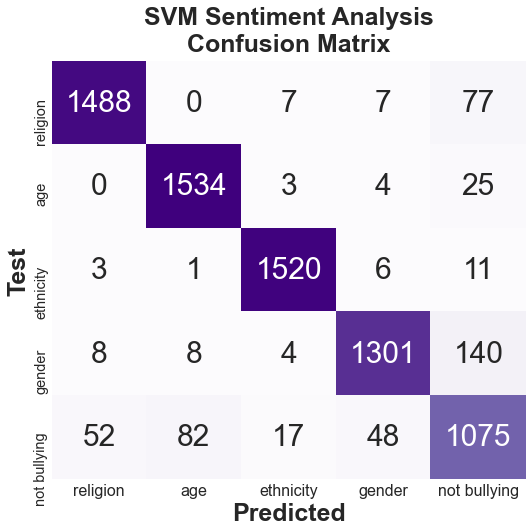

In [103]:
conf_matrix(y_test,svm_pred,'SVM Sentiment Analysis\nConfusion Matrix', sentiments)

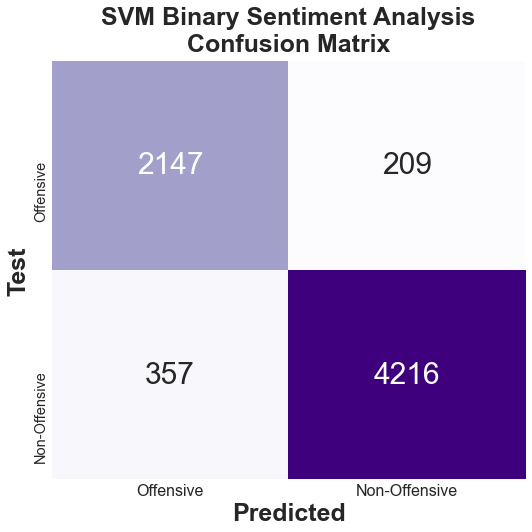

In [101]:
conf_matrix(y_test_bin,svm_pred_bin,'SVM Binary Sentiment Analysis\nConfusion Matrix', labels)

# KNN

In [102]:
from sklearn.neighbors import KNeighborsClassifier

In [98]:
knn_clf = KNeighborsClassifier(weights = 'distance')
knn_clf.fit(X_train_tf, y_train)

KNeighborsClassifier(weights='distance')

In [103]:
knn_clf = KNeighborsClassifier(weights = 'distance')
knn_clf.fit(X_train_tf_bin, y_train_bin)

KNeighborsClassifier(weights='distance')

In [104]:
knn_clf.score(X_test_tf, y_test)

0.762736325588108

In [ ]:
knn_clf.score(X_test_tf_bin, y_test_bin)

In [106]:
knn_pred = knn_clf.predict(X_test_tf)

In [105]:
knn_pred_bin = knn_clf.predict(X_test_tf_bin)

In [107]:
print('Classification Report for KNN:\n',classification_report(y_test, knn_pred, target_names=sentiments))

Classification Report for KNN:
               precision    recall  f1-score   support

    religion       0.89      0.81      0.85      1579
         age       0.84      0.87      0.85      1566
   ethnicity       0.83      0.91      0.87      1541
      gender       0.81      0.83      0.82      1461
not bullying       0.66      0.60      0.63      1274

    accuracy                           0.81      7421
   macro avg       0.81      0.81      0.80      7421
weighted avg       0.81      0.81      0.81      7421



In [106]:
print('Classification Report for KNN Binary:\n',classification_report(y_test_bin, knn_pred_bin, target_names=labels))

Classification Report for KNN Binary:
                precision    recall  f1-score   support

    Offensive       0.66      0.62      0.64      2356
Non-Offensive       0.81      0.83      0.82      4573

     accuracy                           0.76      6929
    macro avg       0.74      0.73      0.73      6929
 weighted avg       0.76      0.76      0.76      6929



In [107]:
conf_matrix(y_test,knn_pred,'KNN Sentiment Analysis\nConfusion Matrix', sentiments)

NameError: name 'y_test' is not defined

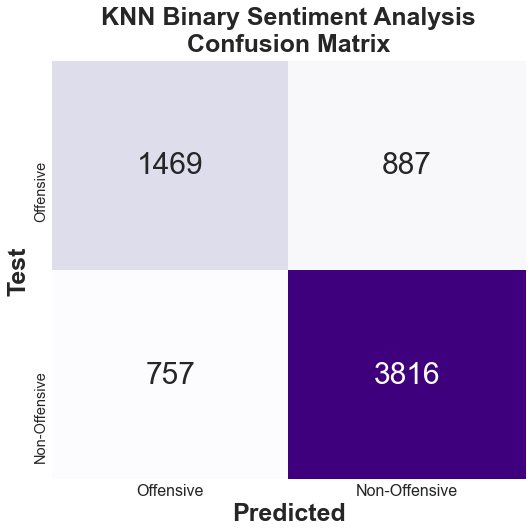

In [110]:
conf_matrix(y_test_bin,knn_pred_bin,'KNN Binary Sentiment Analysis\nConfusion Matrix', labels)

# Decision trees

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [66]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_tf, y_train)

DecisionTreeClassifier()

In [60]:
dt_clf.score(X_test_tf, y_test)

0.9114918835351713

In [61]:
dt_clf.score(X_test_tf_bin, y_test_bin)

NameError: name 'X_test_tf_bin' is not defined

In [62]:
dt_pred = dt_clf.predict(X_test_tf)

In [116]:
dt_pred_bin = dt_clf.predict(X_test_tf_bin)

In [63]:
print('Classification Report for Decision Trees:\n',classification_report(y_test, dt_pred, target_names=sentiments))

Classification Report for Decision Trees:
               precision    recall  f1-score   support

    religion       0.95      0.93      0.94      1589
         age       0.98      0.96      0.97      1576
   ethnicity       0.97      0.98      0.97      1549
      gender       0.88      0.87      0.87      1521
not bullying       0.78      0.82      0.80      1527

    accuracy                           0.91      7762
   macro avg       0.91      0.91      0.91      7762
weighted avg       0.91      0.91      0.91      7762



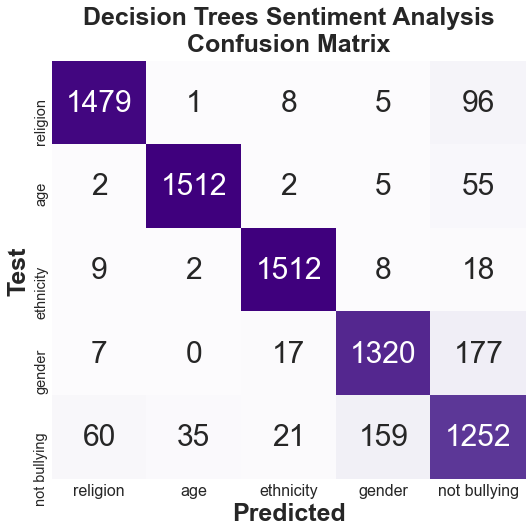

In [64]:
conf_matrix(y_test,dt_pred,'Decision Trees Sentiment Analysis\nConfusion Matrix', sentiments)

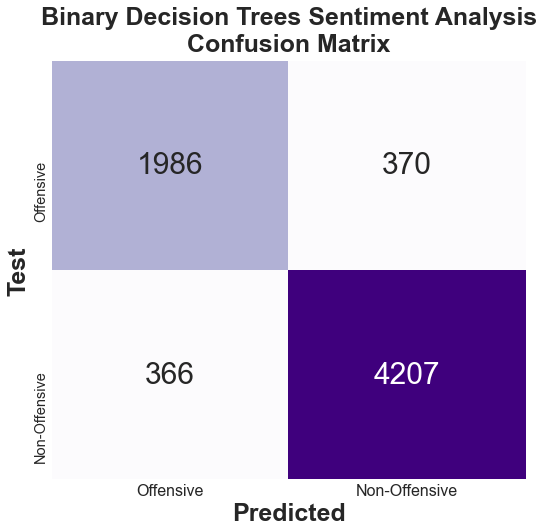

In [119]:
conf_matrix(y_test_bin,dt_pred_bin,'Binary Decision Trees Sentiment Analysis\nConfusion Matrix', labels)

# Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

In [115]:
lr_clf= LogisticRegression()
lr_clf.fit(X_train_tf, y_train)

C:\Users\chira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [121]:
lr_clf= LogisticRegression()
lr_clf.fit(X_train_tf_bin, y_train_bin)

LogisticRegression()

In [116]:
lr_clf.score(X_test_tf, y_test)

0.9307370974262229

In [122]:
lr_clf.score(X_test_tf_bin, y_test_bin)

0.9119642083994804

In [123]:
lr_pred_bin = lr_clf.predict(X_test_tf_bin)

In [123]:
print('Classification Report for Logistic Regression:\n',classification_report(y_test, lr_pred, target_names=sentiments))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

    religion       0.96      0.94      0.95      1579
         age       0.95      0.97      0.96      1566
   ethnicity       0.98      0.98      0.98      1541
      gender       0.95      0.89      0.92      1461
not bullying       0.80      0.86      0.82      1274

    accuracy                           0.93      7421
   macro avg       0.93      0.93      0.93      7421
weighted avg       0.93      0.93      0.93      7421



In [124]:
print('Classification Report for Binary Logistic Regression:\n',classification_report(y_test_bin, lr_pred_bin, target_names=labels))

Classification Report for Binary Logistic Regression:
                precision    recall  f1-score   support

    Offensive       0.85      0.90      0.87      2356
Non-Offensive       0.94      0.92      0.93      4573

     accuracy                           0.91      6929
    macro avg       0.90      0.91      0.90      6929
 weighted avg       0.91      0.91      0.91      6929



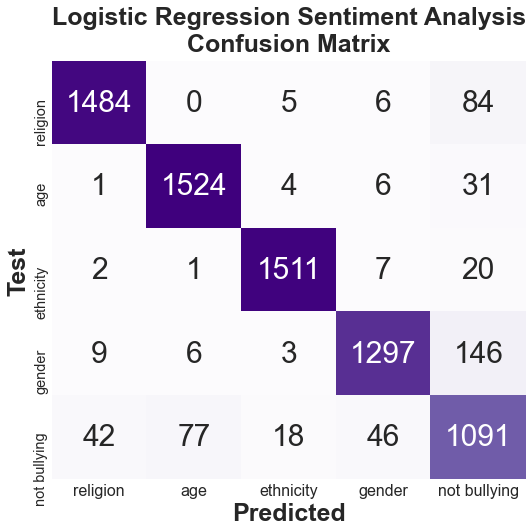

In [154]:
conf_matrix(y_test,lr_pred,'Logistic Regression Sentiment Analysis\nConfusion Matrix', sentiments)

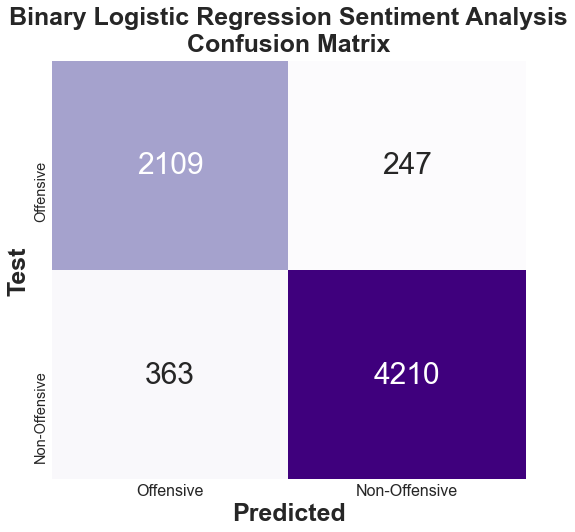

In [125]:
conf_matrix(y_test_bin,lr_pred_bin,'Binary Logistic Regression Sentiment Analysis\nConfusion Matrix', labels)

# Naive Bayes

Finally we can instantiate the Naive Bayes model.

In [126]:
nb_clf = MultinomialNB()

In [43]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [127]:
nb_clf.fit(X_train_tf_bin, y_train_bin)

MultinomialNB()

In [44]:
nb_pred = nb_clf.predict(X_test_tf)

In [128]:
nb_pred_bin = nb_clf.predict(X_test_tf_bin)

In [45]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91      1579
         age       0.80      0.98      0.88      1566
   ethnicity       0.90      0.92      0.91      1542
      gender       0.89      0.85      0.87      1462
not bullying       0.84      0.47      0.60      1274

    accuracy                           0.85      7423
   macro avg       0.86      0.84      0.84      7423
weighted avg       0.86      0.85      0.84      7423



In [129]:
print('Binary Classification Report for Naive Bayes:\n',classification_report(y_test_bin, nb_pred_bin, target_names=labels))

Binary Classification Report for Naive Bayes:
                precision    recall  f1-score   support

    Offensive       0.91      0.51      0.66      2356
Non-Offensive       0.80      0.97      0.88      4573

     accuracy                           0.82      6929
    macro avg       0.85      0.74      0.77      6929
 weighted avg       0.83      0.82      0.80      6929



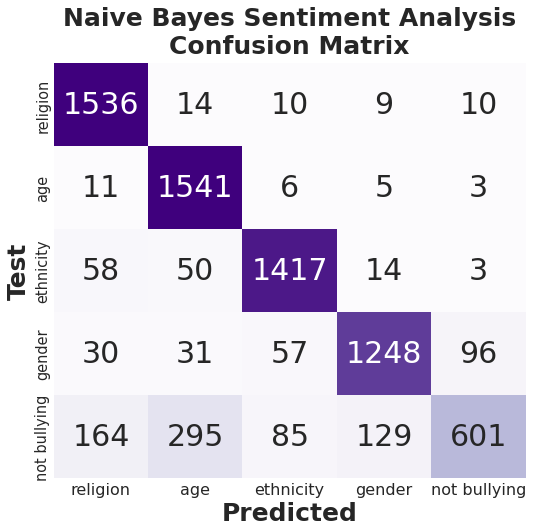

In [46]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

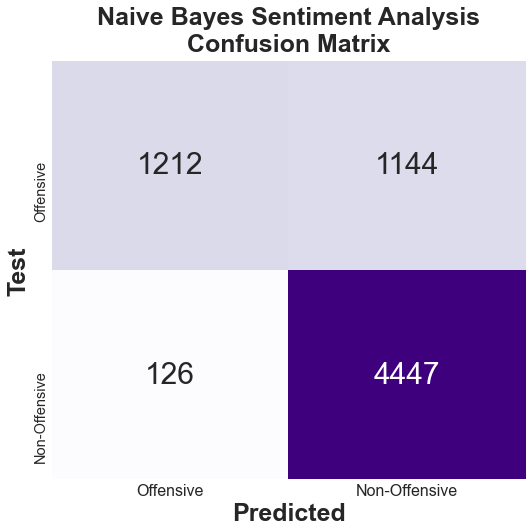

In [131]:
conf_matrix(y_test_bin,nb_pred_bin,'Naive Bayes Sentiment Analysis\nConfusion Matrix', labels)

**The performance scores of the algorithm is very good, with an overall accurcy of 85%.<br>
We can observe how the predictions for the more populated classes have very high F1 scores (over 85%), while for the class "non-cyberbullying" the score is much lower.**

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# PyTorch Bi-LSTM RNN

In this section, we will define a custom Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

# Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [132]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [48]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [141]:
vocabulary, tokenized_column = Tokenize(df_public["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [49]:
df["text_clean"].iloc[10]

'love best respons hotcak manag film noncommitt meh adolesc mkr'

This sentence is transformed to the vector:

In [50]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,    66,   219,   503,
        8001,  1300,  1142, 13587,  4686,  9804,    34])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [51]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

In [142]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


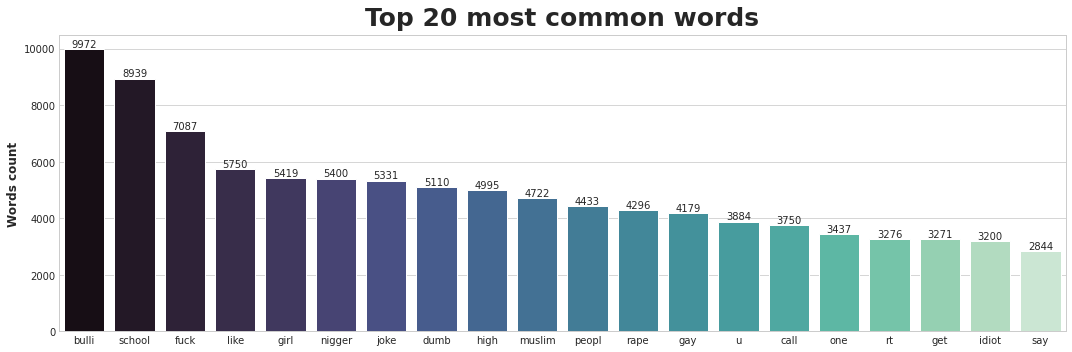

In [52]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

C:\Users\chira\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

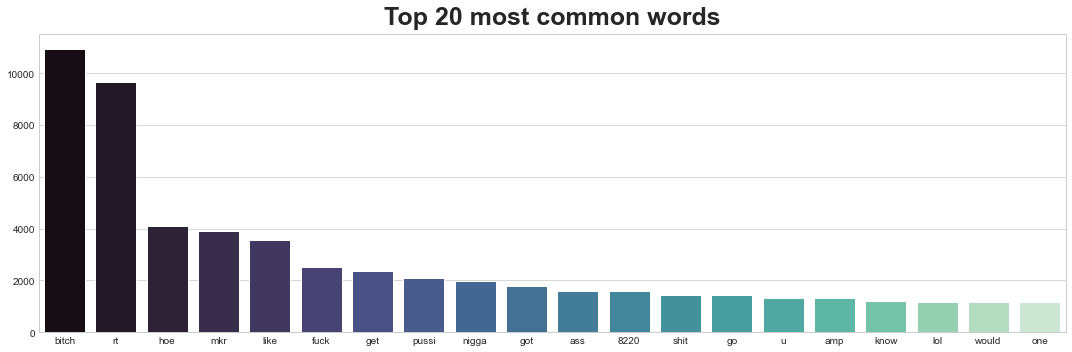

In [143]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [53]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [144]:
Word2vec_train_data_bin = list(map(lambda x: x.split(), X_train_bin))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [145]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [55]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [146]:
word2vec_model = Word2Vec(Word2vec_train_data_bin, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [147]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 23358


In [148]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [58]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (33009, 200)


In [149]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (23358, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [160]:
X = tokenized_column
y = df_public['label'].values

In [161]:
X = tokenized_column
y = df_public['label'].values

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [163]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [164]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0,  8480],
       [    1, 16462]], dtype=int64)

And then apply random oversampling on the training set.

In [156]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [157]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 16462],
       [    1, 16462]], dtype=int64)

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [178]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [166]:
BATCH_SIZE = 32

In [179]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling

Finally we can start the LSTM modeling. We start by setting some hyperparameters.

In [189]:
NUM_CLASSES = 2 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [190]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [191]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(23358, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


C:\Users\chira\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [192]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

# LSTM Training loop 

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [193]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 90.734012).  Saving model ...
	Train_loss : 0.3415 Val_loss : 0.2342
	Train_acc : 84.050% Val_acc : 90.734%
Epoch 2:Validation accuracy did not increase
	Train_loss : 0.1702 Val_loss : 0.2425
	Train_acc : 93.405% Val_acc : 89.898%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1180 Val_loss : 0.2629
	Train_acc : 95.788% Val_acc : 89.353%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0860 Val_loss : 0.2980
	Train_acc : 96.955% Val_acc : 89.426%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0641 Val_loss : 0.3653
	Train_acc : 97.798% Val_acc : 88.808%


In [194]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [195]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [196]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=labels))

ValueError: Number of classes, 2, does not match size of target_names, 32. Try specifying the labels parameter

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (32).

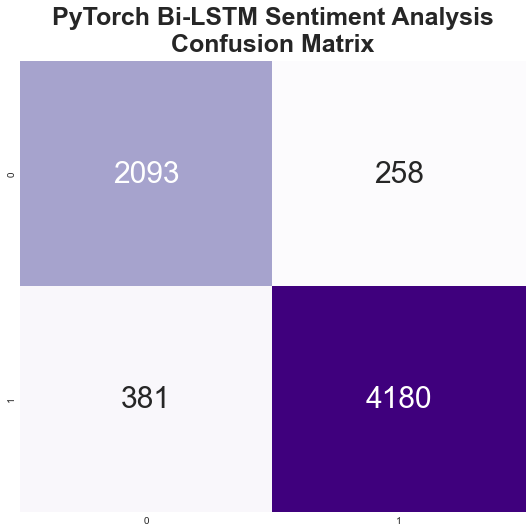

In [198]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', labels)

**The performance scores of the algorithm are very high, with an overall accuracy of 94%.**<br>
**In particular, the F1 scores for the more populated classes are over 95%**

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [200]:
df_public

,label,text,text_clean,text_len
0,1,So Drasko just said he was impressed the girls...,drasko said impress girl cook half chicken coo...,11
2,1,Drasko they didn't cook half a bird you idiot ...,drasko cook half bird idiot mkr,6
4,1,Hopefully someone cooks Drasko in the next ep ...,hope someon cook drasko next ep mkr,7
6,1,of course you were born in serbia...you're as ...,cours born serbiay fuck serbian film mkr,7
7,1,These girls are the equivalent of the irritati...,girl equival irrit asian girl coupl year ago w...,12
...,...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthafin lie 8220 right tl trash 8230 mine bib...,11
24779,0,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart babi drove redneck crazi,8
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...,11
24781,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie,6


In [201]:
X = df_public['text_clean'].values
y = df_public['label'].values

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [203]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [80]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [81]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [204]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 16462],
       [    1, 16462]], dtype=int64)

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [205]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Then we define a custom tokenizer function using the loaded tokenizer.

In [206]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [207]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  62


We can choose the max length as 128.

In [209]:
MAX_LEN = 64

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [210]:
train_inputs, train_masks = bert_tokenizer(X_train)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\chira\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [211]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [212]:
batch_size = 32

In [213]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [214]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Add possibility to freeze the BERT model
        # to avoid fine tuning BERT params (usually leads to worse results)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [215]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Defint the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [216]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [217]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\chira\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed 

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [95]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [96]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.622880   |   39.12  
   200    |   0.262643   |   38.71  
   300    |   0.242833   |   38.67  
   400    |   0.237186   |   38.67  
   500    |   0.223161   |   38.69  
   600    |   0.193918   |   38.65  
   700    |   0.196520   |   38.62  
   800    |   0.182920   |   38.74  
   887    |   0.178209   |   33.62  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.261636    |  0.173281  |       94.16       |  354.86  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.136883   |   39.02  
   2

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [97]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [98]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [99]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.97      0.96      0.96      1579
         age       0.98      0.98      0.98      1566
   ethnicity       0.99      0.99      0.99      1542
      gender       0.93      0.91      0.92      1462
not bullying       0.84      0.87      0.86      1274

    accuracy                           0.95      7423
   macro avg       0.94      0.94      0.94      7423
weighted avg       0.95      0.95      0.95      7423



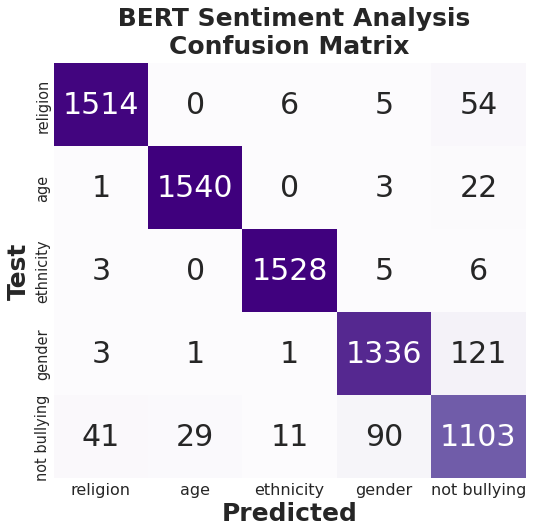

In [100]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)